# 📝 Intro & Summary  📝
We are predicting a binary classification problem using an unknown dataset with varied features
#### As per the competition page:
*This competition is an opportunity to explore various methods for identifying and exploiting these feature interactions*

This give us an indication that we have features which have relationships between them and have interacted in some way. \
The assumption being that, in order to improve our prediction accuracy we will have to understand how these interactions occured and apply feature engineering and selection techniques 

# 📩 Import Libraries 📩 

In [1]:
# Data and visualization
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from collections import Counter
import itertools

# Memory management 
import gc 

#modelling
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.calibration import calibration_curve, CalibratedClassifierCV

In [2]:
# parameters 
sns.set_theme()

CALIBRATION = True
EPOCHS = 5000

# 💾 Load Data 💾

In [3]:
train = pd.read_csv("../input/tabular-playground-series-may-2022/train.csv",index_col = 0)
test = pd.read_csv("../input/tabular-playground-series-may-2022/test.csv",index_col = 0)
sub = pd.read_csv("../input/tabular-playground-series-may-2022/sample_submission.csv",index_col = 0)

# 🌟 Basic EDA 🌟

In [4]:
train.head()

,f_00,f_01,f_02,f_03,f_04,f_05,f_06,f_07,f_08,f_09,...,f_22,f_23,f_24,f_25,f_26,f_27,f_28,f_29,f_30,target
id,,,,,,,,,,,,,,,,,,,,,
0,-1.373246,0.238887,-0.243376,0.567405,-0.647715,0.839326,0.113133,1,5,1,...,-2.540739,0.766952,-2.730628,-0.208177,1.363402,ABABDADBAB,67.609153,0,0,0
1,1.697021,-1.710322,-2.230332,-0.545661,1.113173,-1.552175,0.447825,1,3,4,...,2.278315,-0.633658,-1.217077,-3.782194,-0.058316,ACACCADCEB,377.096415,0,0,1
2,1.681726,0.616746,-1.027689,0.810492,-0.609086,0.113965,-0.708660,1,0,2,...,-1.385775,-0.520558,-0.009121,2.788536,-3.703488,AAAEABCKAD,-195.599702,0,2,1
3,-0.118172,-0.587835,-0.804638,2.086822,0.371005,-0.128831,-0.282575,3,2,1,...,0.572594,-1.653213,1.686035,-2.533098,-0.608601,BDBBAACBCB,210.826205,0,0,1
4,1.148481,-0.176567,-0.664871,-1.101343,0.467875,0.500117,0.407515,3,3,0,...,-3.912929,-1.430366,2.127649,-3.306784,4.371371,BDBCBBCHFE,-217.211798,0,1,1


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 900000 entries, 0 to 899999
Data columns (total 32 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   f_00    900000 non-null  float64
 1   f_01    900000 non-null  float64
 2   f_02    900000 non-null  float64
 3   f_03    900000 non-null  float64
 4   f_04    900000 non-null  float64
 5   f_05    900000 non-null  float64
 6   f_06    900000 non-null  float64
 7   f_07    900000 non-null  int64  
 8   f_08    900000 non-null  int64  
 9   f_09    900000 non-null  int64  
 10  f_10    900000 non-null  int64  
 11  f_11    900000 non-null  int64  
 12  f_12    900000 non-null  int64  
 13  f_13    900000 non-null  int64  
 14  f_14    900000 non-null  int64  
 15  f_15    900000 non-null  int64  
 16  f_16    900000 non-null  int64  
 17  f_17    900000 non-null  int64  
 18  f_18    900000 non-null  int64  
 19  f_19    900000 non-null  float64
 20  f_20    900000 non-null  float64
 21  f_21    90

In [6]:
train.describe(include= "object")

,f_27
count,900000
unique,741354
top,BBBBBBCJBC
freq,12


In [7]:
train.describe()

,f_00,f_01,f_02,f_03,f_04,f_05,f_06,f_07,f_08,f_09,...,f_21,f_22,f_23,f_24,f_25,f_26,f_28,f_29,f_30,target
count,900000.000000,900000.000000,900000.000000,900000.000000,900000.000000,900000.000000,900000.000000,900000.000000,900000.000000,900000.000000,...,900000.000000,900000.000000,900000.000000,900000.000000,900000.000000,900000.000000,900000.000000,900000.000000,900000.000000,900000.000000
mean,-0.000286,0.001165,0.001174,-0.001368,-0.000571,0.000284,-0.000709,2.031460,2.057998,2.362431,...,-0.156307,-0.009273,-0.369459,-0.342738,0.176549,0.357591,-0.380876,0.345661,1.002654,0.486488
std,0.998888,0.999193,1.000514,1.000175,1.000167,0.999875,0.999942,1.656172,1.590955,1.637706,...,2.484706,2.450797,2.453405,2.386941,2.416959,2.476020,238.773054,0.475584,0.818989,0.499818
min,-4.599856,-4.682199,-4.642676,-4.658816,-4.748501,-4.750214,-4.842919,0.000000,0.000000,0.000000,...,-13.310146,-11.853530,-12.301097,-11.416189,-11.918306,-14.300577,-1229.753052,0.000000,0.000000,0.000000
25%,-0.675490,-0.675162,-0.674369,-0.676114,-0.675909,-0.673437,-0.674876,1.000000,1.000000,1.000000,...,-1.820063,-1.645585,-2.019739,-1.955956,-1.440424,-1.261598,-159.427418,0.000000,0.000000,0.000000
50%,0.001144,0.002014,0.002218,-0.002227,-0.001662,-0.000438,-0.001492,2.000000,2.000000,2.000000,...,-0.152668,0.030850,-0.390966,-0.340746,0.160912,0.404212,-0.519808,0.000000,1.000000,0.000000
75%,0.674337,0.675021,0.677505,0.672544,0.673789,0.675028,0.674749,3.000000,3.000000,3.000000,...,1.507071,1.661676,1.255408,1.266673,1.795928,2.028219,158.987357,1.000000,2.000000,1.000000
max,4.749301,4.815699,4.961982,4.454920,4.948983,4.971881,4.822668,15.000000,16.000000,14.000000,...,14.455426,11.344080,12.247100,12.389844,12.529179,12.913041,1229.562577,1.000000,2.000000,1.000000


In [8]:
# check row duplicates 
train[train.duplicated()]

,f_00,f_01,f_02,f_03,f_04,f_05,f_06,f_07,f_08,f_09,...,f_22,f_23,f_24,f_25,f_26,f_27,f_28,f_29,f_30,target
id,,,,,,,,,,,,,,,,,,,,,


In [9]:
# column duplicates
train.apply(lambda x : x.duplicated().sum())

f_00           0
f_01           0
f_02           0
f_03           0
f_04           0
f_05           0
f_06           0
f_07      899984
f_08      899984
f_09      899985
f_10      899985
f_11      899986
f_12      899984
f_13      899987
f_14      899986
f_15      899985
f_16      899984
f_17      899986
f_18      899986
f_19           0
f_20           0
f_21           0
f_22           0
f_23           0
f_24           0
f_25           0
f_26           0
f_27      158646
f_28           0
f_29      899998
f_30      899997
target    899998
dtype: int64

<h3 style="color: green">🗒️ Notes🗒️</h3>

* No null values with float, int and object values
* 1 object column with text 
* Duplicates values in multiple columns with the Text/object column being the most important to investigate

# 📉 Deep Dive  📈

## Target

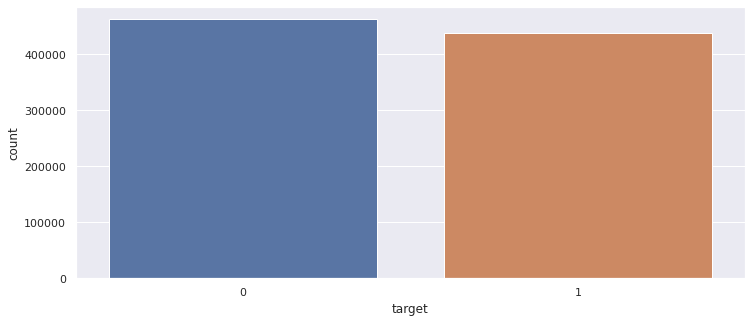

In [10]:
plt.figure(figsize= (12,5))
sns.countplot(x= train["target"])
plt.show()

## Train vs Test: Histograms and Countplots

In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 900000 entries, 0 to 899999
Data columns (total 32 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   f_00    900000 non-null  float64
 1   f_01    900000 non-null  float64
 2   f_02    900000 non-null  float64
 3   f_03    900000 non-null  float64
 4   f_04    900000 non-null  float64
 5   f_05    900000 non-null  float64
 6   f_06    900000 non-null  float64
 7   f_07    900000 non-null  int64  
 8   f_08    900000 non-null  int64  
 9   f_09    900000 non-null  int64  
 10  f_10    900000 non-null  int64  
 11  f_11    900000 non-null  int64  
 12  f_12    900000 non-null  int64  
 13  f_13    900000 non-null  int64  
 14  f_14    900000 non-null  int64  
 15  f_15    900000 non-null  int64  
 16  f_16    900000 non-null  int64  
 17  f_17    900000 non-null  int64  
 18  f_18    900000 non-null  int64  
 19  f_19    900000 non-null  float64
 20  f_20    900000 non-null  float64
 21  f_21    90

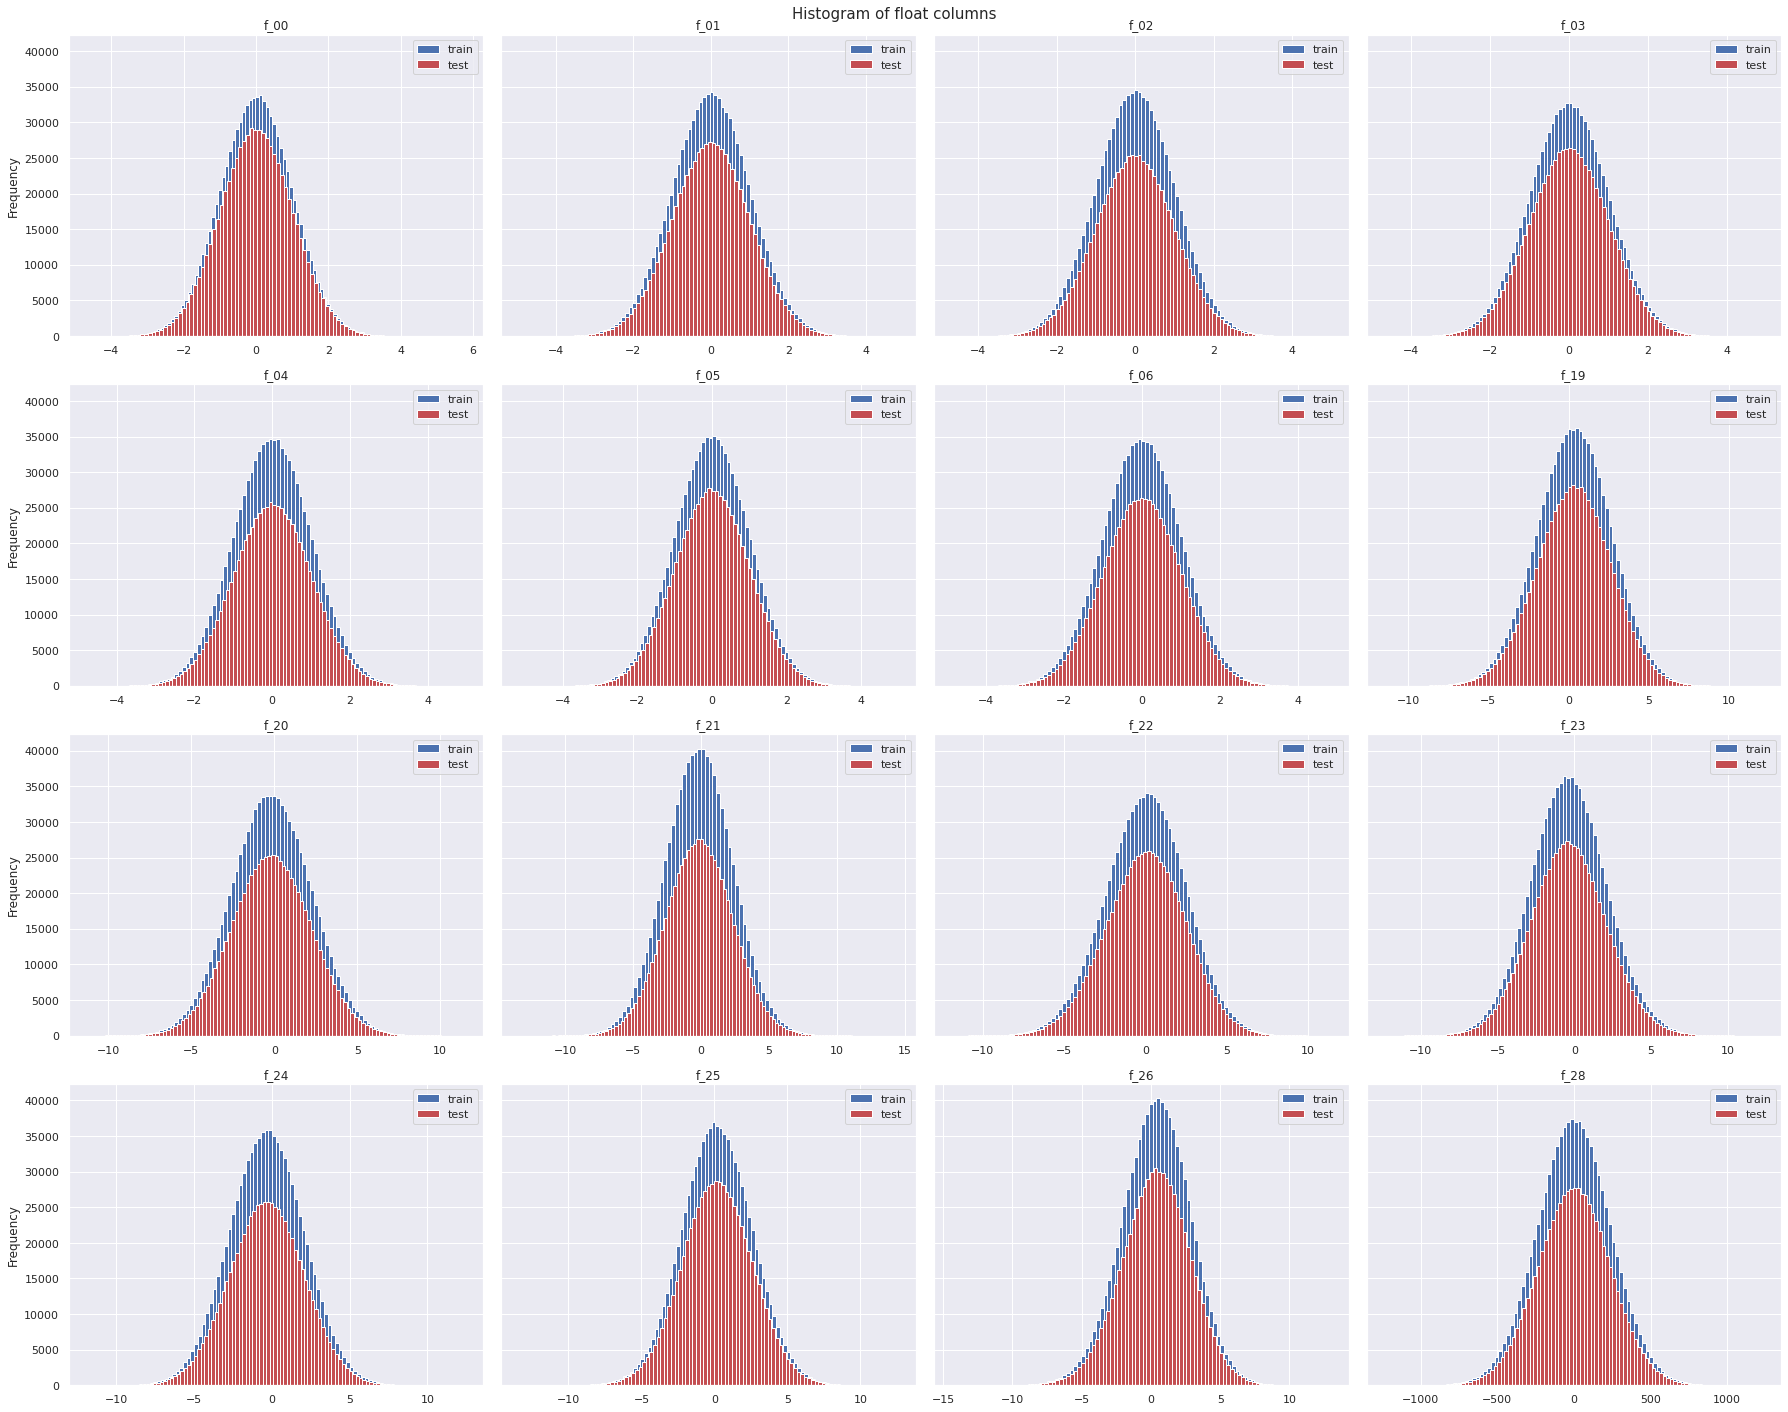

In [12]:
fig, ax = plt.subplots(4,4, figsize = (25,20) , sharey= True)
ax = ax.ravel()

for i,col in enumerate(train.dtypes[train.dtypes =="float64"].index):
    train[col].plot(ax = ax[i], kind = "hist", bins = 100, color = "b")
    test[col].plot(ax = ax[i], kind = "hist", bins = 100, color = "r")
    ax[i].legend(["train", "test"])
    ax[i].set_title(f"{col}")
fig.suptitle("Histogram of float columns", fontsize=15)
plt.tight_layout()
plt.show()

<h3 style="color: green">🗒️ Notes🗒️</h3>

* Normal Gaussian curve for all Float columns -> this is a good sign for ML models 

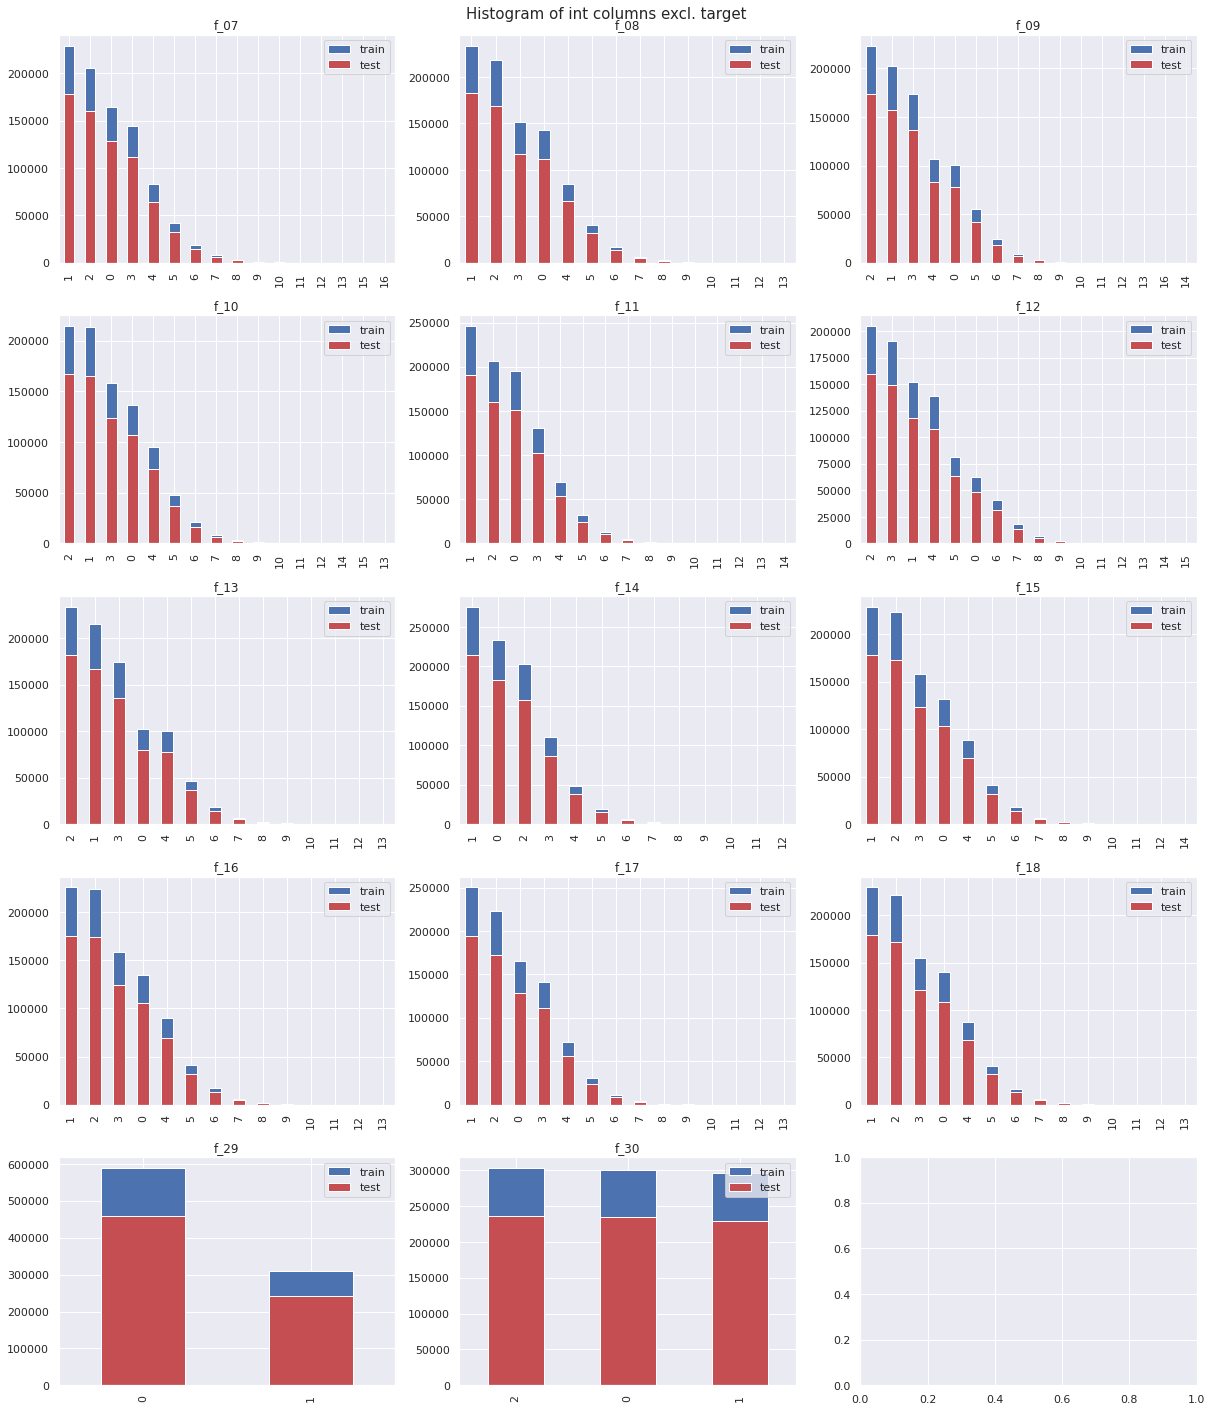

In [13]:
fig, ax = plt.subplots(5,3, figsize = (17,20))
ax = ax.ravel()

for i,col in enumerate(train.dtypes[(train.dtypes =="int64") & (train.dtypes.index != "target") ].index):
    train[col].value_counts().plot(ax = ax[i], kind = "bar",color = "b")
    test[col].value_counts().plot(ax = ax[i], kind = "bar",color = "r")
    ax[i].legend(["train", "test"])
    ax[i].set_title(f"{col}")
fig.suptitle("Histogram of int columns excl. target", fontsize=15)
plt.tight_layout()
plt.show()

## Target Analysis: Histograms and Countplots

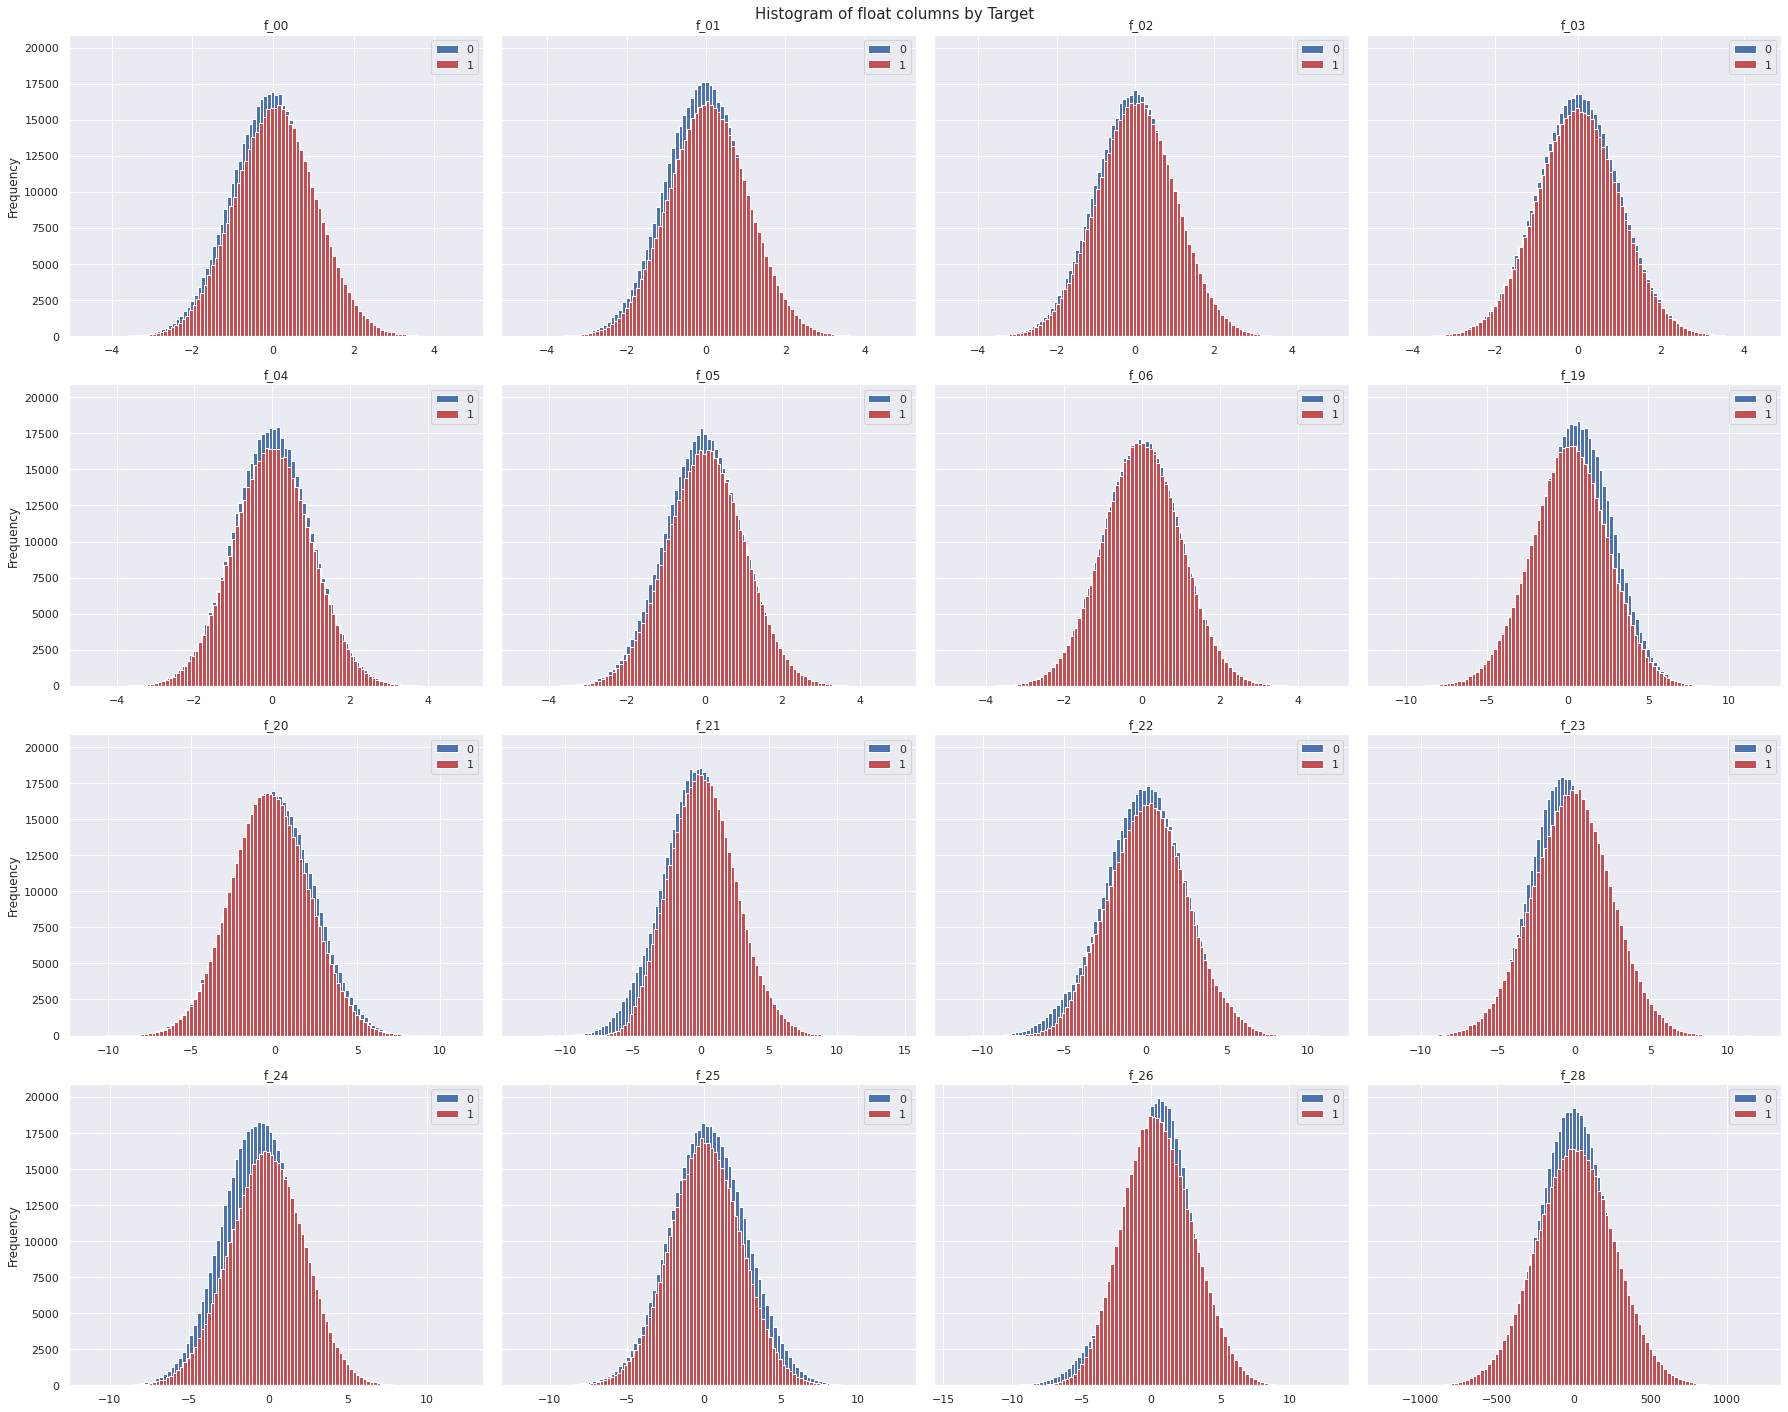

In [14]:
fig, ax = plt.subplots(4,4, figsize = (25,20) , sharey= True)
ax = ax.ravel()

for i,col in enumerate(train.dtypes[train.dtypes =="float64"].index):
    train[train["target"]==0][col].plot(ax = ax[i], kind = "hist", bins = 100, color = "b")
    train[train["target"]==1][col].plot(ax = ax[i], kind = "hist", bins = 100, color = "r")
    ax[i].legend(["0", "1"])
    ax[i].set_title(f"{col}")
fig.suptitle("Histogram of float columns by Target", fontsize=15)
plt.tight_layout()
plt.show()

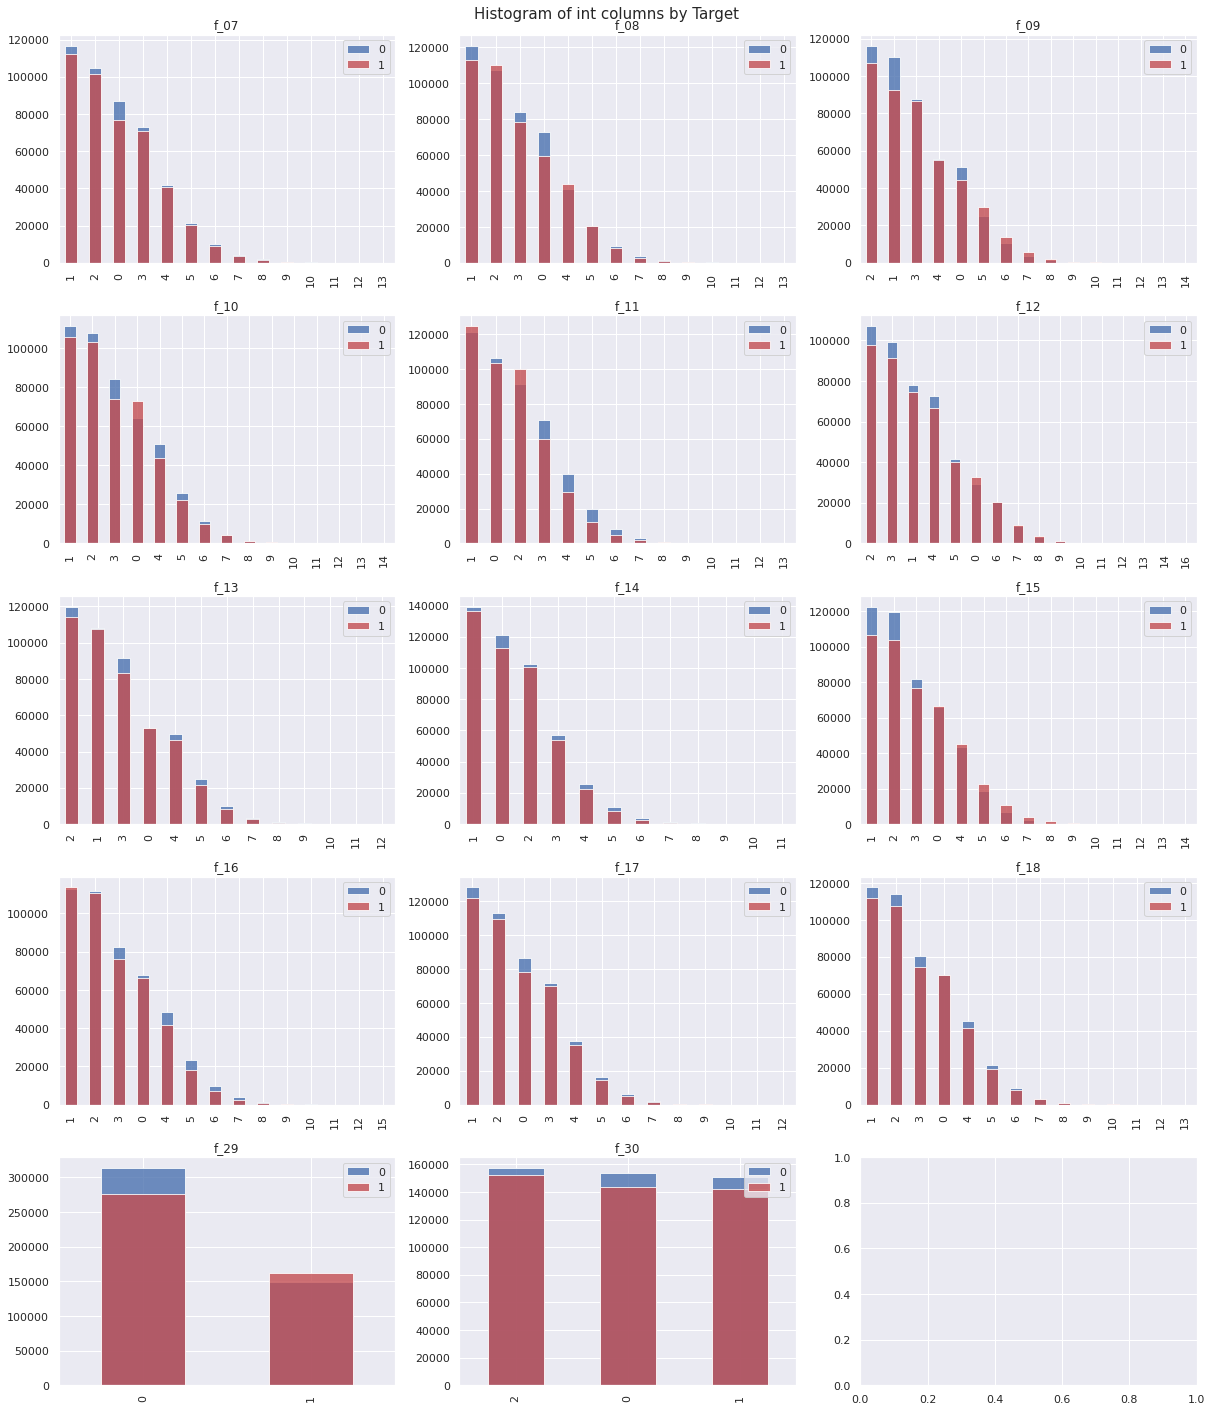

In [15]:
fig, ax = plt.subplots(5,3, figsize = (17,20))
ax = ax.ravel()

for i,col in enumerate(train.dtypes[(train.dtypes =="int64") & (train.dtypes.index != "target") ].index):
    train[train["target"]==0][col].value_counts().plot(ax = ax[i], kind = "bar",color = "b", alpha = 0.8)
    train[train["target"]==1][col].value_counts().plot(ax = ax[i], kind = "bar",color = "r", alpha = 0.8)
    ax[i].legend(["0", "1"])
    ax[i].set_title(f"{col}")
fig.suptitle("Histogram of int columns by Target", fontsize=15)
plt.tight_layout()
plt.show()

<h3 style="color: green">🗒️ Notes🗒️</h3>

All plots dont have huge differences per target. However f_29 and f_30 columns look to be classification columns 

## Correlation & feature relationships 
This can be quite details and would require some Feature selection processes if done correctly \
For now we will look at correlation only and come back to this another time 

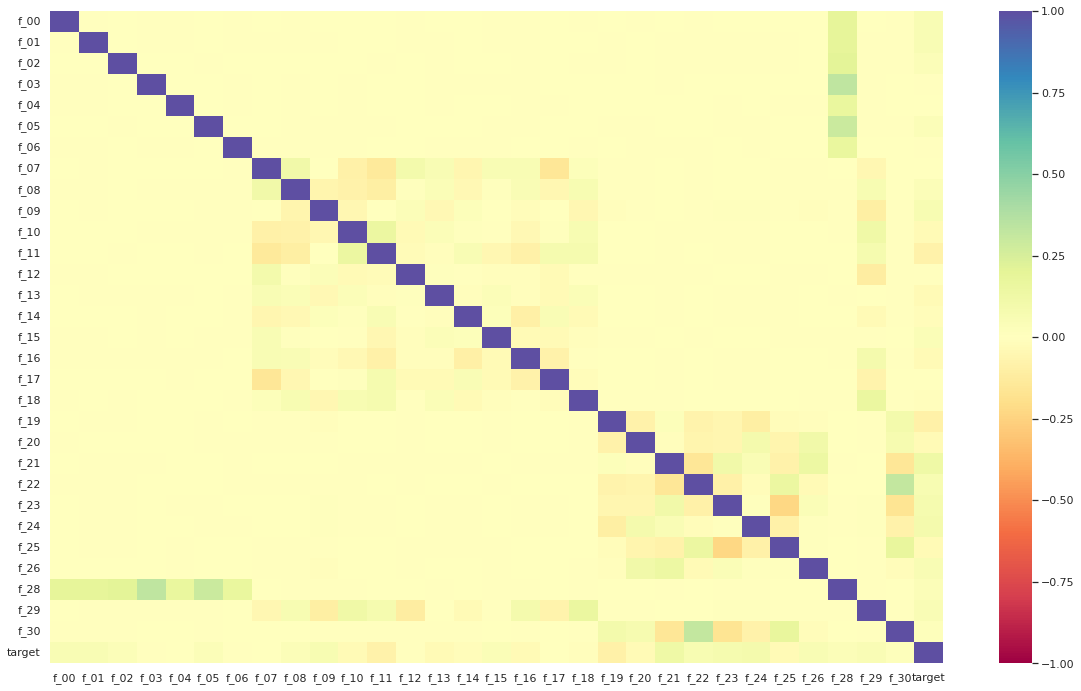

In [16]:
plt.figure(figsize= (20,12))
sns.heatmap(train.corr(),vmin=-1, vmax= 1, cmap= "Spectral")
plt.show()

<h3 style="color: green">🗒️ Notes🗒️</h3>

Not much here w.r.t correlation, we will move on 

In [17]:
# plt.figure(figsize = (20,20))
# sns.pairplot(train[train.columns[train.dtypes =="int64"]], hue = "target")

# plt.title("Pairplot of numerical columns against Target")
# plt.show()

## Text Analysis: Total Letters

In [18]:
# length of text values
display(train["f_27"].str.len().unique())
display(test["f_27"].str.len().unique())

array([10])

array([10])

In [19]:
#get count of all letters by target
def letter_counter(df):
    count = Counter({})
    for row in df["f_27"]:
        count += Counter(row)
    return count 
train_0 = letter_counter(train[train["target"]==0])
train_1 = letter_counter(train[train["target"]==1])
train_1

Counter({'A': 1113418,
         'C': 647013,
         'D': 445506,
         'E': 263165,
         'B': 1357943,
         'K': 22600,
         'H': 42464,
         'F': 142946,
         'S': 24600,
         'T': 25120,
         'G': 75221,
         'I': 28867,
         'J': 24048,
         'N': 23662,
         'Q': 23688,
         'O': 24011,
         'P': 24246,
         'M': 23290,
         'R': 23930,
         'L': 22652})

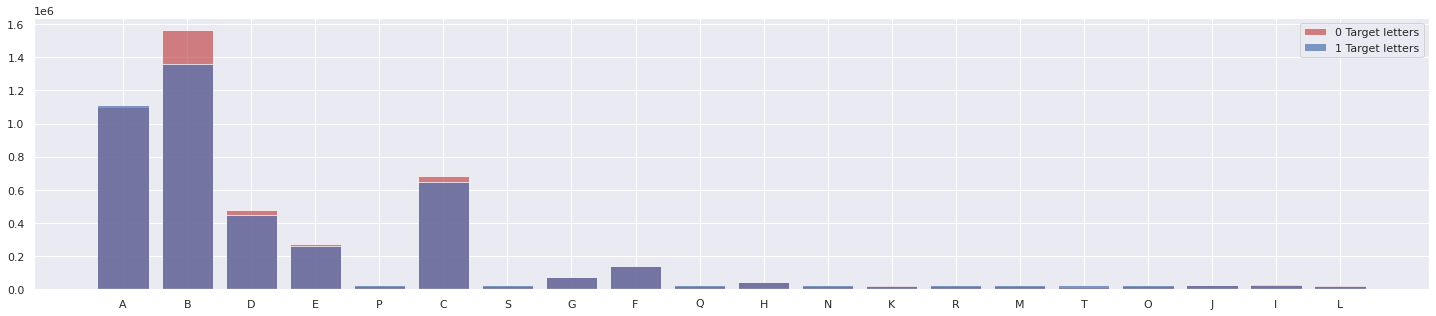

In [20]:
plt.figure(figsize= (25,5))
plt.bar(train_0.keys(), train_0.values(), color = "r", alpha = 0.7)
plt.bar(train_1.keys(), train_1.values(), color = "b", alpha = 0.7)

plt.legend(["0 Target letters","1 Target letters"])
plt.show()

In [21]:
def perc_letters(df):
    let_df = pd.DataFrame.from_dict(df, orient='index')
    let_df = let_df/ let_df.sum()
    return let_df

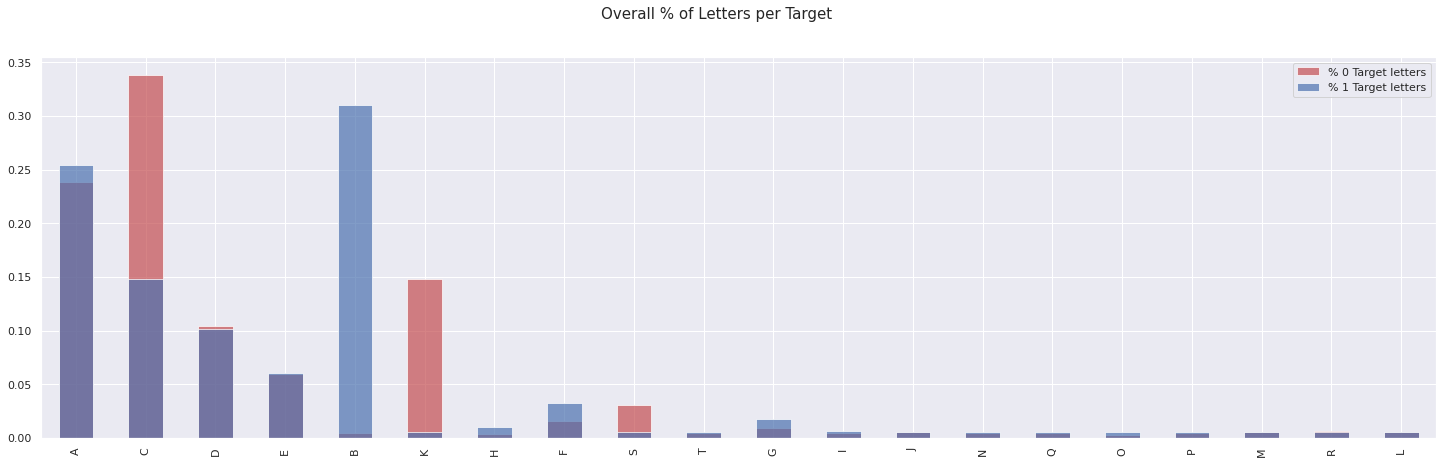

In [22]:
# plot % of letters 
fig, ax = plt.subplots(figsize= (25,7))
perc_letters(train_0).plot(ax=ax, kind = "bar", color = "r", alpha = 0.7)
perc_letters(train_1).plot(ax=ax, kind = "bar", color = "b", alpha = 0.7 )

ax.legend(["% 0 Target letters", "% 1 Target letters"]);
fig.suptitle("Overall % of Letters per Target", fontsize=15)
plt.show()

<h3 style="color: green">🗒️ Notes🗒️</h3>

* Target 0 will have a higher % of C and K letters (compared to Target 1) 
* Target 1 will have a higher % of B letters and F letters (comapred to Target 0)

## Text Analysis: By letter

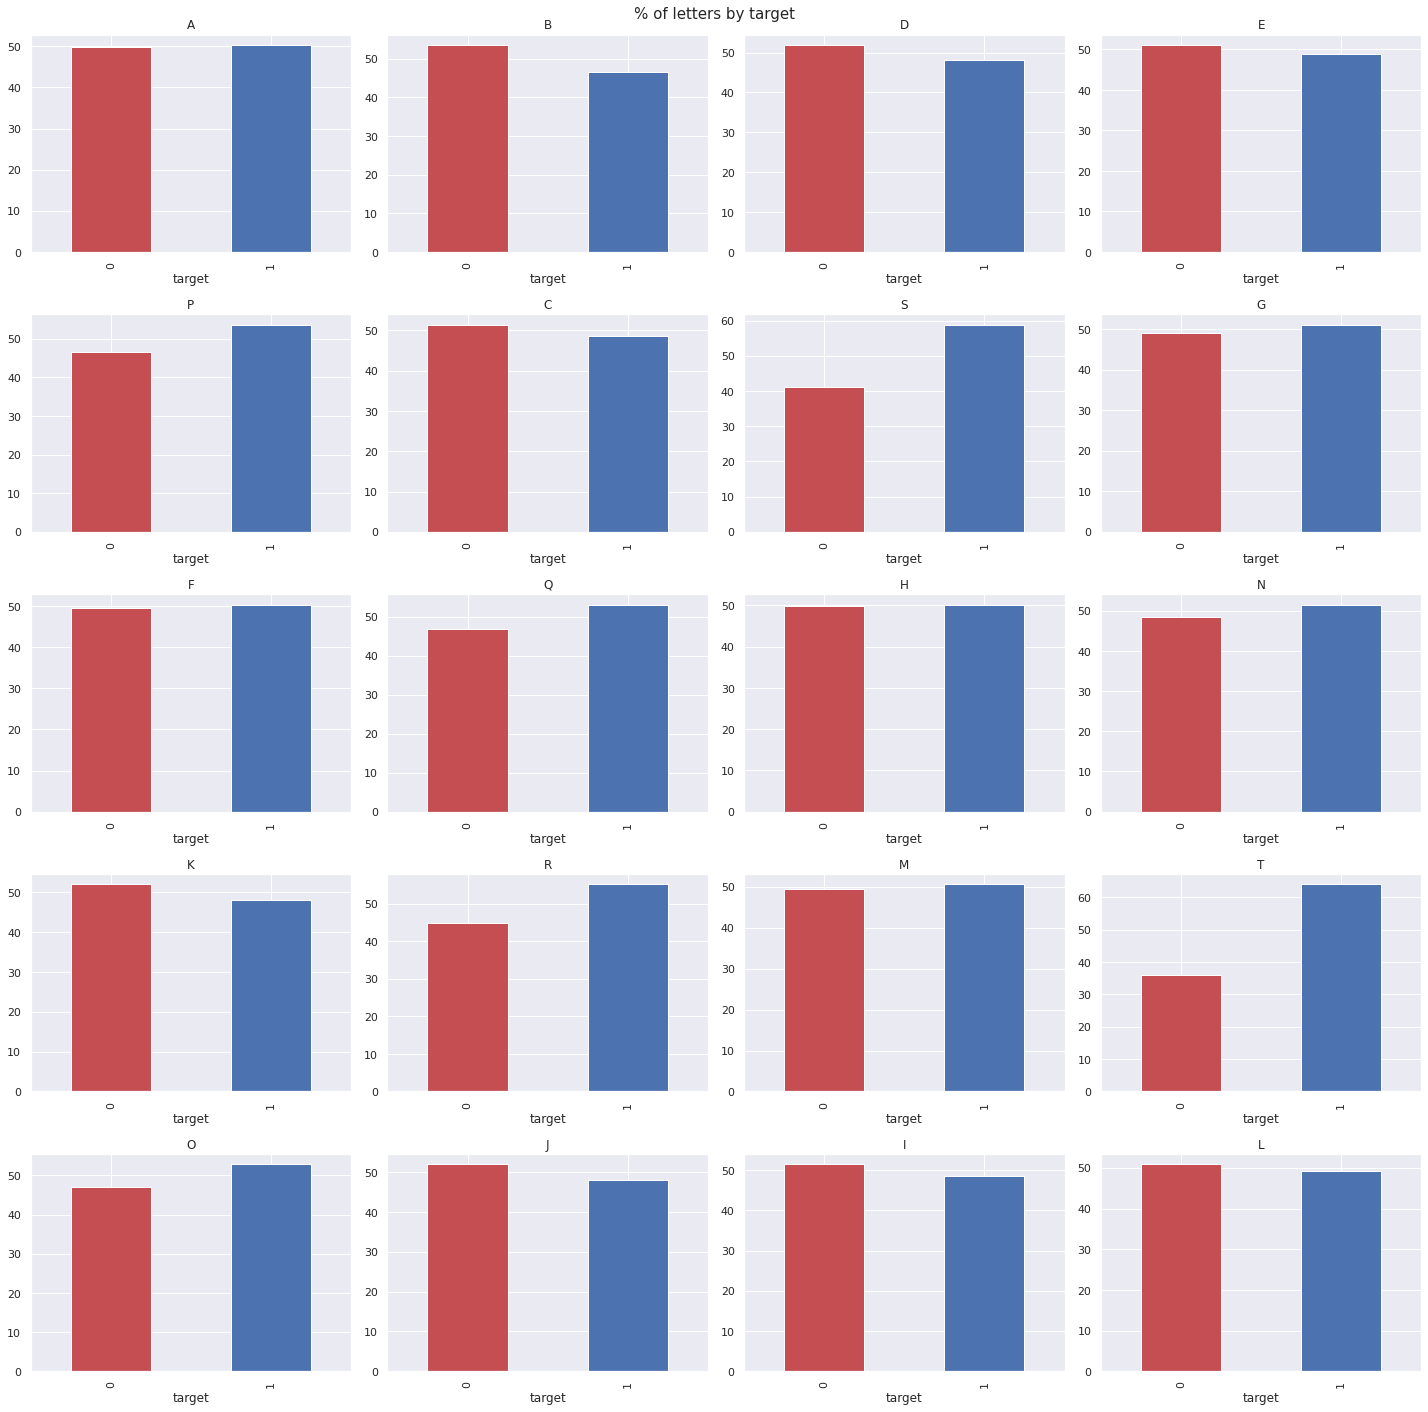

In [23]:
fig, ax = plt.subplots(5,4, figsize= (20,20))
ax = ax.ravel()

for i, letter in enumerate(train_0.keys()):
    #create columns-> count of letters in text
    train[letter] = train["f_27"].str.count(letter)
    test[letter] = test["f_27"].str.count(letter)
    
    # plot % of letters in each word, groupby target
    percentage = (train.groupby("target")[letter].sum()/ train.groupby("target")[letter].sum().sum())*100
    percentage.plot(kind= "bar",ax= ax[i],color = ["r","b"])
    ax[i].set_title(f"{letter}")
    
fig.suptitle("% of letters by target", fontsize = 15)
plt.tight_layout()
plt.show()

<h3 style="color: green">🗒️ Notes🗒️</h3>

* Text values with large number of 'S' letters have a higher chance of being 1 Target, same with letter 'T' (there are a few others with minor differences R, O, Q , P, B) 

# 🚀 Base Model 🚀

In [24]:
# drop the text column as we already have features created earlier
X = train.drop(["target","f_27"],axis =1)
y= train["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

In [25]:
model = lgb.LGBMClassifier(n_jobs = -1, n_estimators = EPOCHS)
model.fit(X_train,y_train, eval_set=[(X_test,y_test)], callbacks = [lgb.early_stopping(30)],eval_metric="auc")

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[4817]	valid_0's auc: 0.972352	valid_0's binary_logloss: 0.218726


LGBMClassifier(n_estimators=5000)

In [26]:
val_preds = model.predict_proba(X_test)
y_preds = model.predict_proba(X_train)

print("Intrinsic AUC:", roc_auc_score(y_train, y_preds[:,1]))
print("Validation AUC:", roc_auc_score(y_test, val_preds[:, 1] ))

Intrinsic AUC: 0.9944531487450525
Validation AUC: 0.9723524900080525


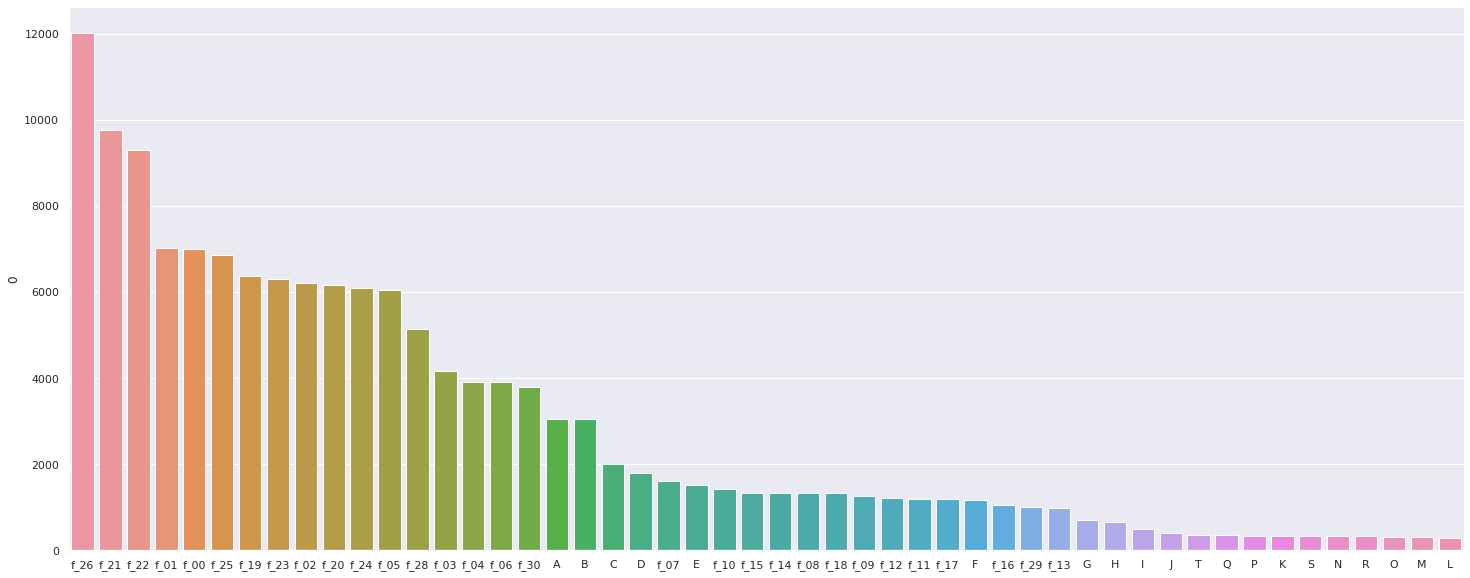

In [27]:
feat_importance = pd.DataFrame(data = model.feature_importances_, index= train.drop(["target","f_27"],axis =1).columns).sort_values(ascending = False, by= [0] )

plt.figure(figsize= (25,10))
sns.barplot(y= feat_importance[0], x= feat_importance.index)
plt.show()

In [28]:
feat_importance[feat_importance[0] ==0]

,0


## Calibration 
Taken from my kernels from [last month's TPS ](https://www.kaggle.com/code/slythe/calibrated-xgboost-human-activity-recognition)

In [29]:
prob_true, prob_pred = calibration_curve(y_test, val_preds[:,1], n_bins=10)

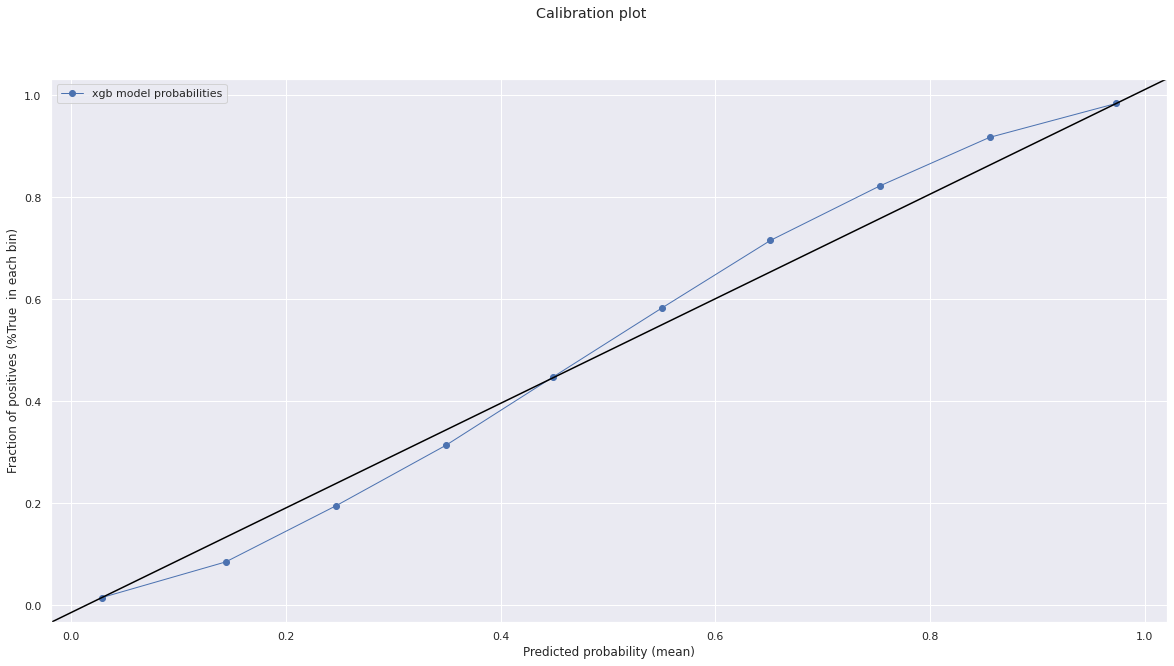

In [30]:
fig, ax = plt.subplots(figsize=(20,10))
plt.plot(prob_pred,prob_true, marker='o', linewidth=1, label='xgb model probabilities')

# reference line
line = mlines.Line2D([0, 1], [0, 1], color='black')
transform = ax.transAxes
line.set_transform(transform)
ax.add_line(line)
#plt.axvline(x=0.2, color = "r")
fig.suptitle('Calibration plot')
ax.set_xlabel('Predicted probability (mean)')
ax.set_ylabel('Fraction of positives (%True  in each bin)')
plt.legend()
plt.show()

In [31]:
calibrator = CalibratedClassifierCV(model, method = "isotonic", cv='prefit')
calibrator.fit(X_test, y_test)
cal_preds = calibrator.predict_proba(X_test)

print("Validation AUC:" , roc_auc_score(y_test, val_preds[:, 1] ))
print("Calibrated AUC:" , roc_auc_score(y_test, cal_preds[:, 1] ))

Validation AUC: 0.9723524900080525
Calibrated AUC: 0.9724425915416628


# ❎ Cross validation ❎

In [32]:
cv = KFold(n_splits = 5, shuffle = True,random_state=42)

In [33]:
preds = []
auc_cv = []
for fold, (idx_train, idx_val) in enumerate(cv.split(X,y)):
    print("\n")
    print("#"*10, f"Fold: {fold}","#"*10)
    X_train , X_test = X.iloc[idx_train] , X.iloc[idx_val]
    y_train , y_test = y[idx_train] , y[idx_val]
    
    model = lgb.LGBMClassifier(n_jobs = -1, n_estimators = EPOCHS)
    model.fit(X_train,y_train, eval_set=[(X_test,y_test)], callbacks = [lgb.early_stopping(30)],eval_metric="auc")
    
    if CALIBRATION:
        calibrator = CalibratedClassifierCV(model, method = "isotonic", cv='prefit')
        calibrator.fit(X_test, y_test)
        auc = roc_auc_score(y_test, calibrator.predict_proba(X_test)[:, 1])
        print("\n Calibration AUC:" , auc)
        preds.append(calibrator.predict_proba(test.drop("f_27",axis =1))[:, 1])
    else:
        auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
        print("\n Validation AUC:" , auc)
        preds.append(model.predict_proba(test.drop("f_27",axis =1))[:, 1])
        
    del model
    del X_train
    del X_test
    del y_train
    del y_test
    del calibrator
    
    auc_cv.append(auc)
    
print("FINAL AUC: ", np.mean(auc_cv))



########## Fold: 0 ##########
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[5000]	valid_0's auc: 0.97366	valid_0's binary_logloss: 0.214162

 Calibration AUC: 0.9737985638492129


########## Fold: 1 ##########
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[5000]	valid_0's auc: 0.973595	valid_0's binary_logloss: 0.214116

 Calibration AUC: 0.9737146333473756


########## Fold: 2 ##########
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[5000]	valid_0's auc: 0.972832	valid_0's binary_logloss: 0.217239

 Calibration AUC: 0.9729844188827064


########## Fold: 3 ##########
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[4827]	valid_0's auc: 0.973001	valid_0's binary_logloss: 0.216067

 Calibration AUC: 0.9731188911549806


########## Fold: 4 ##########
Tr

# 📡 Submission 📡

In [34]:
sub["target"] = np.array(preds).mean(axis =0)
sub.to_csv("submission.csv")
sub

,target
id,
900000,0.991098
900001,0.987213
900002,0.002368
900003,0.013581
900004,0.727993
...,...
1599995,0.352364
1599996,0.974957
1599997,0.631608


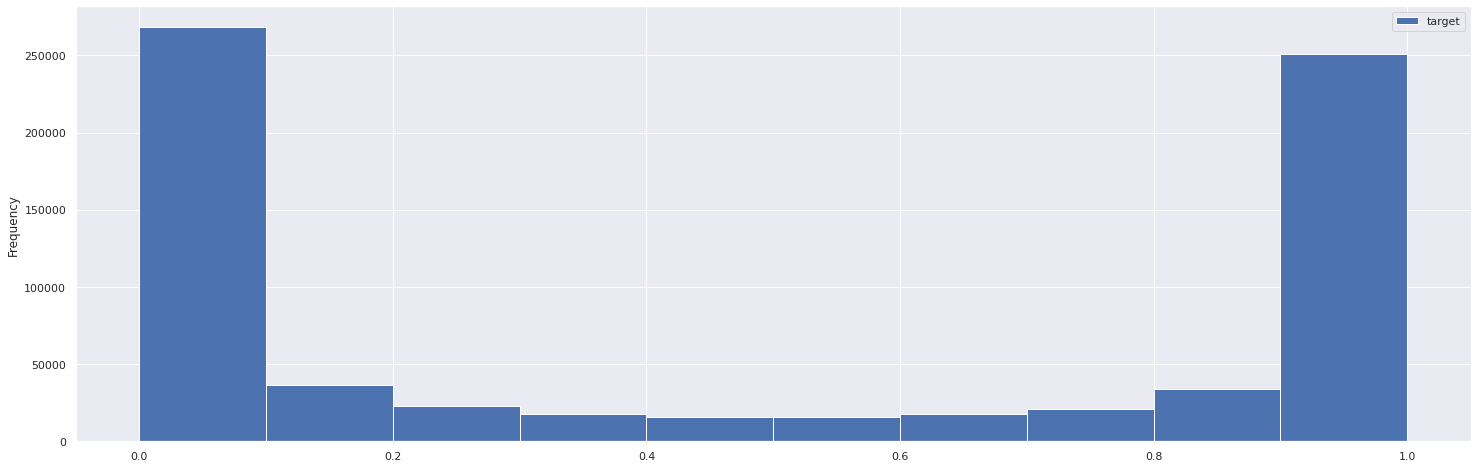

In [35]:
sub.plot(kind= "hist",figsize= (25,8))
plt.show()

# Bonus Scatterplot
Scatterplot of all float columns - this causes memory issues so was moved to its own notebook 
https://www.kaggle.com/slythe/scatterplot-tps-may

# 🚧🚧Notebook Under Construction 🚧🚧
